In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

# Data Preprocessing

In [40]:
data = pd.read_csv('../data/data_train.csv', index_col=0)

# rename column and turn ot uint8
data.rename(columns={'Prediction': 'Rating'}, inplace=True)
data['Rating'] = data['Rating'].astype('uint8')

# get user and movie id by splitting index given in format rX_cY
data['UserId'] = data.index.str.split('_').str[0].str[1:].astype('int32')
data['MovieId'] = data.index.str.split('_').str[1].str[1:].astype('int32')

# subtract min UserId and MovieID to get indices starting at 0
data['UserId'] = data['UserId'] - data['UserId'].min()
data['MovieId'] = data['MovieId'] - data['MovieId'].min()

# make int again
data['UserId'] = data['UserId'].astype('int32')
data['MovieId'] = data['MovieId'].astype('int32')

# reorder columns to UserId, MovieId, Rating
data = data[['UserId', 'MovieId', 'Rating']]

# split into train and val data
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

In [3]:
train_data.head()

,UserId,MovieId,Rating
Id,,,
r5874_c663,5873,662,5
r4711_c367,4710,366,4
r2539_c435,2538,434,1
r7737_c558,7736,557,2
r9631_c791,9630,790,5


In [4]:
train_data.describe()

,UserId,MovieId,Rating
count,941561.000000,941561.000000,941561.000000
mean,5149.112369,482.580407,3.856588
std,2918.447452,274.174986,1.119108
min,0.000000,0.000000,1.000000
25%,2602.000000,246.000000,3.000000
50%,5247.000000,493.000000,4.000000
75%,7734.000000,690.000000,5.000000
max,9999.000000,999.000000,5.000000


In [41]:
train_mean = train_data['Rating'].mean()
train_std = train_data['Rating'].std()

# standardize ratings
train_data['Rating'] = (train_data['Rating'] - train_mean) / train_std

# TODO try by user or by movie

In [42]:
# function to get sparse matrix from data given as a dataframe with row and column indices
def get_sparse_matrix(data, n_rows, n_cols):
    return csr_matrix((data['Rating'].values, (data['UserId'].values, data['MovieId'].values)), shape=(n_rows, n_cols))

n_rows = train_data['UserId'].max() + 1 # might raise errors if in val set user with larger id
n_cols = train_data['MovieId'].max() + 1 # might raise errors if in val set movie with larger id
train_matrix = get_sparse_matrix(train_data, n_rows, n_cols)

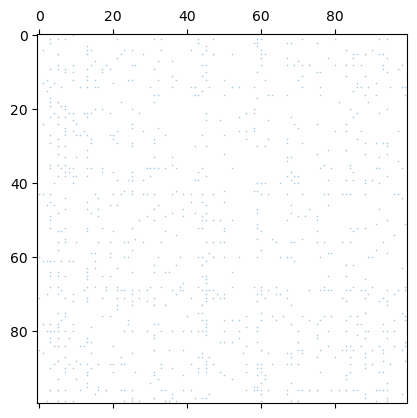

In [6]:
# plot sparse matrix
plt.spy(train_matrix[:100,:100], markersize=0.1)
plt.show()

# ALS algorithm

In [23]:
rank = 224 # number of latent factors
lam = 25 # regularization parameter

# only consider subset
n_rows = 1000
n_cols = 100

# initialize U and V
U = np.random.rand(n_rows, rank)
V = np.random.rand(rank, n_cols)

# function to compute loss
def loss_func(U, V, A, lam):
    loss = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if A[row,col]:
                loss += (A[row,col] - U[row,:] @ V[:,col])**2
    loss += lam * (np.linalg.norm(U)**2 + np.linalg.norm(V)**2)
    return loss

# function to make one step
def make_step_als(U, V, A, lam):
    # U of shape (n_rows, rank)
    # V of shape (rank, n_cols)
    # A of shape (n_rows, n_cols)
    # lam is regularization parameter

    # get parameters
    rank = U.shape[1]
    n_rows = A.shape[0]
    n_cols = A.shape[1]

    # TODO find bug
    # update U adapting lecture script
    B = A @ V.transpose() # offset vector representing movie bias (n_rows, rank)
    Q = np.ndarray((n_cols, rank, rank)) # helper matrix - precompute
    for col in range(n_cols):
        Q[col] = V[:,col] @ V[:,col].transpose()

    for row in range(n_rows):
        sum_r1_mat = 0
        for col in range(n_cols):
            if A[row,col]:
                sum_r1_mat += Q[col,:,:]
        inv = np.linalg.inv(sum_r1_mat + lam * np.identity(rank))
        U[row,:] = B[row,:] @ inv

    # update V following lecture script
    B = U.transpose() @ A # offset vector representing user bias (rank, n_cols)
    Q = np.ndarray((n_rows, rank, rank)) # helper matrix - precompute
    for row in range(n_rows):
        Q[row] = U[row,:].transpose() @ U[row,:]

    for col in range(n_cols):
        sum_r1_mat = 0
        for row in range(n_rows):
            if A[row,col]:
                sum_r1_mat += Q[row,:,:]
        inv = np.linalg.inv(sum_r1_mat + lam * np.identity(rank))
        V[:,col] = inv @ B[:,col]

    return U, V

loss = loss_func(U, V, train_matrix[:n_rows, :n_cols], lam)
print('Step: {}, Loss: {}'.format(-1, loss))
# make steps until convergence
losses = []
for i in range(10):
    U, V = make_step_als(U, V, train_matrix[:n_rows, :n_cols], lam)
    loss = loss_func(U, V, train_matrix[:n_rows, :n_cols], lam)
    losses.append(loss)
    print('Step: {}, Loss: {}'.format(i, loss))


Step: -1, Loss: 32069832.02402144
Step: 0, Loss: 17121.495564588895
Step: 1, Loss: 11408.99243235173
Step: 2, Loss: 10977.721838660156
Step: 3, Loss: 10897.082751660702
Step: 4, Loss: 10869.952898698073
Step: 5, Loss: 10855.931698872897
Step: 6, Loss: 10846.716449598953
Step: 7, Loss: 10839.942092696901
Step: 8, Loss: 10834.699478963623
Step: 9, Loss: 10830.53771203348


# Stochastic Gradient Descent

In [24]:
# function to make one step
def make_step_sgd(U, V, A, row, col, lr):
    # U of shape (n_rows, rank)
    # V of shape (rank, n_cols)
    # A of shape (n_rows, n_cols)

    gradient = - (A[row, col] - (U@V)[row, col])
    u_gradient = gradient * V[:, col]
    U[row, :] = U[row, :] - lr * u_gradient
    v_gradient = gradient * U[row, :]
    V[:, col] = V[:, col] - lr * v_gradient

    return U, V

'''
# let's use pretrained highly regularized initialization from above

rank = 112 # number of latent factors

# only consider subset
n_rows = 1000
n_cols = 100

# initialize U and V
U = np.random.rand(n_rows, rank)
V = np.random.rand(rank, n_cols)
'''

lr = 0.1 # regularization parameter
train_data_scope = train_data[(train_data['UserId'] < n_rows) & (train_data['MovieId'] < n_cols)]
train_matrix_scope = train_matrix[:n_rows, :n_cols]

loss = loss_func(U, V, train_matrix_scope, lam=0)
print('Step: {}, Loss: {}'.format(-1, loss))

# make steps until convergence
losses = []
for i in range(1000):
    # select random point from train_data_scope
    row, col = train_data_scope.sample(1)[['UserId', 'MovieId']].values[0]
    U, V = make_step_sgd(U, V, train_matrix_scope, row, col, lr)
    loss = loss_func(U, V, train_matrix_scope, lam=0)
    losses.append(loss)
    print('Step: {}, Loss: {}'.format(i, loss))

Step: -1, Loss: 10549.292490575395
Step: 0, Loss: 10549.314403256772
Step: 1, Loss: 10549.104456991205
Step: 2, Loss: 10548.95676035625
Step: 3, Loss: 10549.055281445979
Step: 4, Loss: 10549.046061346437
Step: 5, Loss: 10549.016921495562
Step: 6, Loss: 10549.014160275483
Step: 7, Loss: 10549.013246173732
Step: 8, Loss: 10549.014610798053
Step: 9, Loss: 10549.016609602078
Step: 10, Loss: 10549.017034007278
Step: 11, Loss: 10549.164024979367
Step: 12, Loss: 10547.236983119625
Step: 13, Loss: 10547.292451693309
Step: 14, Loss: 10547.393794841135
Step: 15, Loss: 10547.198815045116
Step: 16, Loss: 10546.294568184185
Step: 17, Loss: 10546.291392627161
Step: 18, Loss: 10546.262786734682
Step: 19, Loss: 10546.463898715894
Step: 20, Loss: 10546.444558287407
Step: 21, Loss: 10546.401726712435
Step: 22, Loss: 10546.364701045737
Step: 23, Loss: 10546.387991504915
Step: 24, Loss: 10546.440786059791
Step: 25, Loss: 10546.273440223262
Step: 26, Loss: 10546.276562213445
Step: 27, Loss: 10546.385657427

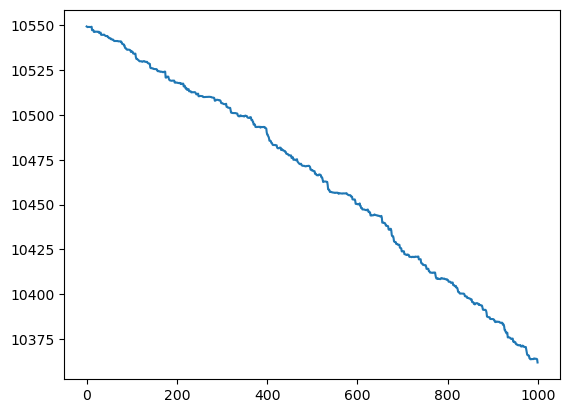

In [25]:
plt.plot(losses)
plt.show()

#  ALS/SGD Inference

In [26]:
prediction_matrix = U @ V

# make dataframe out of flatten matrix with features UserId and MovieId
prediction_df = pd.DataFrame(prediction_matrix.flatten(), columns=['Prediction'])
prediction_df['UserId'] = np.repeat(np.arange(n_rows), n_cols)
prediction_df['MovieId'] = np.tile(np.arange(n_cols), n_rows)
prediction_df = prediction_df[['UserId', 'MovieId', 'Prediction']]

# set idx to format rX_cY
prediction_df['idx'] = 'r' + prediction_df['UserId'].astype('str') + '_c' + prediction_df['MovieId'].astype('str')
prediction_df = prediction_df.set_index('idx')

# revert standardization
prediction_df['Prediction'] = prediction_df['Prediction'] * train_std + train_mean
prediction_df.head()

,UserId,MovieId,Prediction
idx,,,
r0_c0,0,0,3.858933
r0_c1,0,1,3.858603
r0_c2,0,2,3.857893
r0_c3,0,3,3.854527
r0_c4,0,4,3.858248


In [31]:
val_data_scope = val_data[(val_data['UserId'] < n_rows) & (val_data['MovieId'] < n_cols)]

# merge with prediction_df
val_data_scope = val_data_scope.merge(prediction_df['Prediction'], left_index=True, right_index=True)
val_data_scope.head()


,UserId,MovieId,Rating,Prediction
r871_c27,870,26,5,3.851554
r981_c46,980,45,3,3.854506
r518_c48,517,47,4,3.842746
r692_c35,691,34,3,3.846139
r81_c15,80,14,3,3.869207


In [32]:
# compute rmse using sklearn
rmse_3 = mean_squared_error(val_data_scope['Rating'], 3 * np.ones(val_data_scope.shape[0]), squared=False)
rmse_mean = mean_squared_error(val_data_scope['Rating'], train_mean * np.ones(val_data_scope.shape[0]), squared=False)
rmse_als = mean_squared_error(val_data_scope['Rating'], val_data_scope['Prediction'], squared=False)
print('Dummy RMSE: {}'.format(rmse_3))
print('Mean RMSE: {}'.format(rmse_mean))
print('ALS + SGD RMSE: {}'.format(rmse_als))

Dummy RMSE: 1.3848909516903134
Mean RMSE: 1.180393227686044
ALS + SGD RMSE: 1.1802513813203652


# KNN
TODO change implementation to calculate similarity by user once, then filter for valid rows.

In [43]:
similarities = cosine_similarity(train_matrix, train_matrix)

In [55]:
max_elements = 1000
k = 3

k_array = np.arange(1, 50, 2)
rmse_array = []

for k in tqdm(k_array):
    predictions = np.zeros(val_data.shape[0])
    for i in range(max_elements):
        user_id, movie_id = val_data.iloc[i][['UserId', 'MovieId']]

        user_id = int(user_id)
        movie_id = int(movie_id)

        train_users = train_matrix[:, movie_id].nonzero()[0]
        prediction = train_matrix[np.argsort(similarities[user_id, train_users])[-k:], movie_id].mean()
        predictions[i] = prediction

    predictions = predictions * train_std + train_mean
    rmse = mean_squared_error(val_data['Rating'][:max_elements], predictions[:max_elements], squared=False)
    rmse_array.append(rmse)

# val_data['Prediction'] = predictions

100%|██████████| 49/49 [01:03<00:00,  1.29s/it]


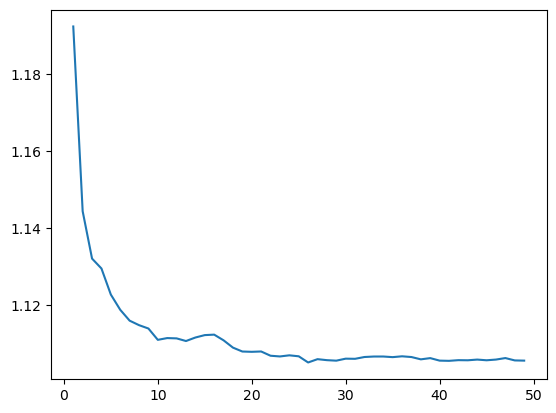

Best k: 26
Best RMSE: 1.1050977813623006


In [57]:
plt.plot(k_array, rmse_array)
plt.show()

print('Best k: {}'.format(k_array[np.argmin(rmse_array)]))
print('Best RMSE: {}'.format(np.min(rmse_array)))

In [33]:
val_data.head()

,UserId,MovieId,Rating,Prediction
Id,,,,
r5062_c706,5061,705,2,3.856588
r9044_c148,9043,147,4,3.885271
r1736_c169,1735,168,4,3.885271
r5270_c877,5269,876,1,3.885271
r6100_c691,6099,690,4,3.856588


In [34]:
# compute rmse using sklearn
rmse_3 = mean_squared_error(val_data['Rating'], 3 * np.ones(val_data.shape[0]), squared=False)
rmse_mean = mean_squared_error(val_data['Rating'], train_mean * np.ones(val_data.shape[0]), squared=False)
rmse_knn = mean_squared_error(val_data['Rating'], val_data['Prediction'], squared=False)
print('Dummy RMSE: {}'.format(rmse_3))
print('Mean RMSE: {}'.format(rmse_mean))
print('KNN RMSE: {}'.format(rmse_knn))

Dummy RMSE: 1.4112094086052875
Mean RMSE: 1.1188557511451012
KNN RMSE: 1.112042736481531
